In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [3]:
#raw_transcripts = pd.read_csv("../data/raw_transcripts.csv", encoding='utf-8')
df = pd.read_csv("../data/posts_transcripts.csv", encoding='utf-8')

df['createTimeISO'] = (
    pd.to_datetime(df['createTimeISO'], utc=True, errors='coerce')
      .dt.tz_convert('Europe/Berlin')
)

nine_months = pd.Timestamp.utcnow() - pd.DateOffset(months=6)
df = df[df['createTimeISO'] >= nine_months]

### Preprocessing


In [4]:
df = df[df['textLanguage'] == 'en']

In [5]:
def combine_text(row, include_description=True):
    # Start with caption
    texts = []
    if pd.notna(row['text']):
        texts.append(str(row['text']))
    if pd.notna(row['transcribed_text']):
        texts.append(str(row['transcribed_text']))
    if include_description and pd.notna(row['video_description']):
        texts.append(str(row['video_description']))
    return ' '.join(texts)


In [6]:
# Create the concatenated text column FIRST
text_cols = ['text', 'video_description', 'transcribed_text']
df['text_all'] = df[text_cols].fillna('').agg(' '.join, axis=1)

In [7]:
# All three fields
#df['processed_text'] = df.apply(lambda row: combine_text(row, include_description=True), axis=1)

# Or, only caption + transcript
df['combined_text'] = df.apply(lambda row: combine_text(row, include_description=False), axis=1)

In [8]:
import re
import spacy

nlp = spacy.load("en_core_web_sm")  # English small model

import emoji
def clean_text(text, stopwords=None, lemmatize=False):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|@\w+", " ", text)
    text = emoji.replace_emoji(text, replace=lambda e, _: f" {e} ")
    text = re.sub(r"[^a-zA-ZäöüÄÖÜß0-9\s#?!\U0001F600-\U0001F64F]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    
    # Use spaCy tokenizer for more robust tokenization
    tokens = [token.text for token in nlp(text)]
    tokens = [re.sub(r"(.)\1{2,}", r"\1\1", t) for t in tokens]

    if stopwords:
        tokens = [t for t in tokens if t not in stopwords and len(t) > 2]
    else:
        tokens = [t for t in tokens if len(t) > 2]

    if lemmatize and tokens:
        doc = nlp(" ".join(tokens))
        tokens = [token.lemma_ for token in doc]

    return " ".join(tokens)


In [9]:
import os
os.environ["NLTK_DATA"] = "/Users/hannahschlaucher/nltk_data"

In [10]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize


nltk.data.path.append('/Users/hannahschlaucher/nltk_data')
nltk.data.path.append('/Users/hannahschlaucher/nltk_data')
nltk.data.path.append('/Users/hannahschlaucher/nltk_data')




def pos_enhanced_preprocessing(text):
    meaningful_pos = {'NN', 'NNS', 'NNP', 'NNPS',
                      'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ',
                      'JJ', 'JJR', 'JJS',
                      'RB', 'RBR', 'RBS'}
    tokens = word_tokenize(text.lower())
    pos_tags = pos_tag(tokens)
    meaningful_tokens = [token for token, pos in pos_tags if pos in meaningful_pos]
    return ' '.join(meaningful_tokens)

#df['combined_text_processed'] = df['combined_text_processed'].apply(pos_enhanced_preprocessing)


In [11]:
from spacy.lang.en.stop_words import STOP_WORDS
stopwords = STOP_WORDS

df['combined_text_processed'] = df['combined_text'].apply(lambda x: clean_text(x, stopwords=stopwords, lemmatize=True))

### Feature engineering

In [12]:
# Get time based categories

# Hour of posting (0–23)
df['hour_posting'] = df['createTimeISO'].dt.hour

# Day of week (0=Monday, …, 6=Sunday)
df['day_of_week'] = df['createTimeISO'].dt.dayofweek

# Is weekend flag (True if Saturday or Sunday)
df['is_weekend'] = df['day_of_week'].isin([5, 6])

# Time period categories
def categorize_period(hour):
    if 5 <= hour < 12:
        return 'morning'
    elif 12 <= hour < 17:
        return 'afternoon'
    elif 17 <= hour < 21:
        return 'evening'
    else:
        return 'night'

df['time_period'] = df['hour_posting'].apply(categorize_period)

In [13]:
#TDIDF 

from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(
    max_features=8000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.95,
    stop_words='english',  # or your own stopword list
    lowercase=False,       # Already lowercased during preprocessing
    analyzer='word',
    token_pattern=r'\b\w+\b'
)

X_tfidf = vectorizer.fit_transform(df['combined_text_processed'])

In [14]:
def extract_text_statistics(text):
    """
    Extract statistical features from text content
    """
    if pd.isna(text) or text == '':
        return pd.Series([0, 0, 0, 0, 0])
    
    # Basic statistics
    word_count = len(str(text).split())
    sentence_count = len(str(text).split('.'))
    
    # Advanced statistics
    avg_word_length = np.mean([len(word) for word in str(text).split()]) if word_count > 0 else 0
    exclamation_count = str(text).count('!')
    question_count = str(text).count('?')
    
    return pd.Series([word_count, sentence_count, 
                     avg_word_length, exclamation_count, question_count])


# Extract text statistics for all text fields
text_stats_columns = ['word_count', 'sentence_count', 
                     'avg_word_length', 'exclamation_count', 'question_count']

df[text_stats_columns] = df['combined_text_processed'].apply(extract_text_statistics)


In [15]:
import re

def extract_hashtags(text):
    """Extract hashtags from text"""
    if pd.isna(text):
        return []
    hashtags = re.findall(r'#\w+', text.lower())
    return [tag.replace('#', '') for tag in hashtags]

# Extract hashtags
df['hashtag_list'] = df['text'].apply(extract_hashtags)


In [16]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.preprocessing import MultiLabelBinarizer

# 1. Flatten all hashtags and count them
all_hashtags = [tag for tags in df['hashtag_list'].dropna() for tag in (tags if isinstance(tags, list) else [])]
hashtag_counts = Counter(all_hashtags)

# 2. Calculate the 40th percentile threshold (so we keep hashtags used more often than 40% of the others)
counts = np.array(list(hashtag_counts.values()))
threshold = np.percentile(counts, 99)  # "above 40th percentile" == 60th percentile and up

# 3. Build the set of most-used hashtags
popular_hashtags = {tag for tag, count in hashtag_counts.items() if count >= threshold}

# 4. Keep only those hashtags for each post
def filter_popular(tags):
    if not isinstance(tags, list):
        return []
    return [tag for tag in tags if tag in popular_hashtags]

df['popular_hashtags'] = df['hashtag_list'].apply(filter_popular)

# 5. One-hot encode
mlb = MultiLabelBinarizer()
hashtag_features = mlb.fit_transform(df['popular_hashtags'])
hashtag_feature_names = ['hashtag_' + h for h in mlb.classes_]
df_hashtag_features = pd.DataFrame(hashtag_features, columns=hashtag_feature_names, index=df.index)



### Define target

In [17]:
Q1   = df["playCount"].quantile(0.25)
Q3   = df["playCount"].quantile(0.75)
IQR  = Q3 - Q1

lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
mask  = df["playCount"].between(lower, upper)

df_clean = df.loc[mask].copy().reset_index(drop=True)

# views_log normalises heavy-tailed reach
df['viral_score']  = np.log1p(df['playCount'])

threshold = df['viral_score'].quantile(0.75)
df['is_viral'] = (df['viral_score'] > threshold).astype(int)

y = df['viral_score']

In [18]:
import numpy as np

# select only numeric cols
num_df = df.select_dtypes(include=[np.number])

# full correlation matrix
corr_matrix = num_df.corr()
#print(corr_matrix)

# list high-corr pairs
upper = corr_matrix.abs().where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = (upper.stack()
                .loc[lambda x: x > 0.7]
                .sort_values(ascending=False))
print(high_corr)


diggCount    commentCount    0.736990
viral_score  is_viral        0.724363
dtype: float64


### Combine all features

In [19]:
from sklearn.preprocessing import StandardScaler
from scipy.sparse import hstack, csr_matrix

additional_cols = [
    'isAd',
    'author_fans',
    'video_duration',
    'isSponsored',
    'hour_posting', 'day_of_week', 'is_weekend', 'time_period',
    'word_count', 'sentence_count',
    'avg_word_length', 'exclamation_count', 'question_count'
]

# 1. Drop rows with NaNs in additional features
df_clean = df.dropna(subset=additional_cols)

# 2. Reset index so everything lines up in order
df_clean = df_clean.reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features.iloc[df_clean.index].reset_index(drop=True)

In [20]:
# 1. Drop rows with NaNs in additional features
df_clean = df.dropna(subset=additional_cols).reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features.iloc[df_clean.index].reset_index(drop=True)

# 2. Drop outliers from df_clean
low, high = 0.0, 1
num_cols = df_clean.select_dtypes(include=[np.number]).columns
mask = np.ones(len(df_clean), dtype=bool)

for col in num_cols:
    p1, p99 = df_clean[col].quantile([low, high])
    mask &= df_clean[col].between(p1, p99)

# Get remaining indices before reset
remaining_idx = df_clean[mask].index

# Apply mask to both DataFrames
df_clean = df_clean.loc[remaining_idx].reset_index(drop=True)
df_hashtag_features_clean = df_hashtag_features_clean.loc[remaining_idx].reset_index(drop=True)


In [21]:
# 3. Concatenate hashtag features to cleaned DataFrame (indices now match)
df_clean = pd.concat([df_clean, df_hashtag_features_clean], axis=1)

# 4. Convert booleans to int
for col in ['isAd', 'isSponsored', 'is_weekend']:
    df_clean[col] = df_clean[col].astype(int)

# 5. One-hot encode 'time_period'
df_clean = pd.get_dummies(df_clean, columns=['time_period'], drop_first=True)

# 6. Prepare final list of feature columns (including hashtag columns)
hashtag_cols = list(df_hashtag_features_clean.columns)
additional_cols_final = (
    [col for col in additional_cols if col != 'time_period'] +
    [c for c in df_clean.columns if c.startswith('time_period_')] +
    hashtag_cols
)

# 7. Extract and standardize features
additional_data = df_clean[additional_cols_final]
scaler = StandardScaler()
additional_data_scaled = scaler.fit_transform(additional_data)
additional_sparse = csr_matrix(additional_data_scaled)

# 8. Make sure your TF-IDF matrix is in the same row order as df_clean
X_tfidf_clean = X_tfidf[df_clean.index]

# If you built X_tfidf on a column of the original df, it matches df_clean row-for-row after .reset_index(drop=True)

# 9. Combine all features
X_combined = hstack([X_tfidf_clean, additional_sparse])

In [22]:
X_combined.shape

(3651, 8086)

### Training model 

In [23]:
print("TF-IDF shape:", X_tfidf_clean.shape)
print("Additional sparse shape:", additional_sparse.shape)
print("Hashtag features shape:", df_hashtag_features.shape)
print("X_combined shape:", X_combined.shape)
print("y length:", len(y))


TF-IDF shape: (3651, 8000)
Additional sparse shape: (3651, 86)
Hashtag features shape: (3651, 71)
X_combined shape: (3651, 8086)
y length: 3651


In [24]:
import numpy as np
from sklearn.model_selection import train_test_split

idx = np.arange(X_combined.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train = X_combined[train_idx]
X_test  = X_combined[test_idx]

y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

In [25]:
from xgboost import XGBRegressor

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# 1. Instantiate model
xgb = XGBRegressor(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1,
    tree_method='hist'
)

# 2. Fit on full training set
xgb.fit(X_train, y_train)

# 3. Evaluate on test set
y_pred = xgb.predict(X_test)
rmse   = np.sqrt(mean_squared_error(y_test, y_pred))
r2     = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")


RMSE: 2.4091
R²:   0.3728


In [26]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = xgb.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")

# Optionally, back-transform predictions if you want original scale:
y_pred_orig = np.expm1(y_pred)
y_test_orig = np.expm1(y_test)


RMSE: 2.4091
R2: 0.3728


In [27]:
import numpy as np
y_mean = y_train.mean()
baseline_rmse = np.sqrt(np.mean((y_test - y_mean)**2))
print("Baseline RMSE:", baseline_rmse)
print("y_train std:", y_train.std())


Baseline RMSE: 3.053416301643408
y_train std: 2.9691601296199512


## Results

In [28]:
import numpy as np
import pandas as pd

# Grab the scaled block (n_samples × 86)
X_scaled = additional_data_scaled  

#Recover the real-unit values for all samples
means  = scaler.mean_    # shape (86,)
scales = scaler.scale_   # shape (86,)
X_orig = X_scaled * scales + means  # still (n_samples, 86)

# 3) Wrap in a DataFrame for easy lookup
df_orig = pd.DataFrame(
    X_orig,
    columns=additional_cols_final,
    index=df_clean.index
)

# 4Slice out the train vs. test rows
df_train_orig = df_orig.loc[train_idx]  
df_test_orig  = df_orig.loc[test_idx]  

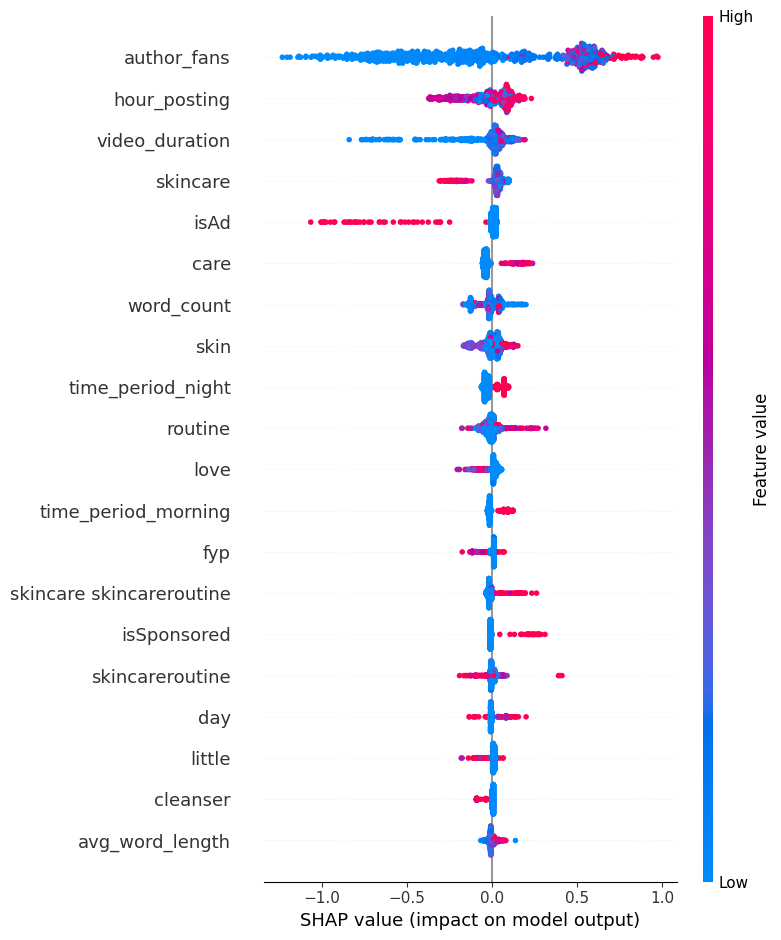

In [29]:
import shap

# Combine feature names
tfidf_feature_names = vectorizer.get_feature_names_out().tolist()
feature_names = tfidf_feature_names + additional_cols_final

# Convert your sparse train/test matrices into DataFrames
X_train_df = pd.DataFrame(
    X_train.toarray(),
    columns=feature_names,
    index=train_idx  
)
X_test_df = pd.DataFrame(
    X_test.toarray(),
    columns=feature_names,
    index=test_idx
)

# SHAP explainer
explainer = shap.TreeExplainer(xgb, X_train_df)  # your trained XGBoost model
shap_values = explainer.shap_values(X_test_df)

shap.summary_plot(shap_values, X_test_df, feature_names=feature_names)

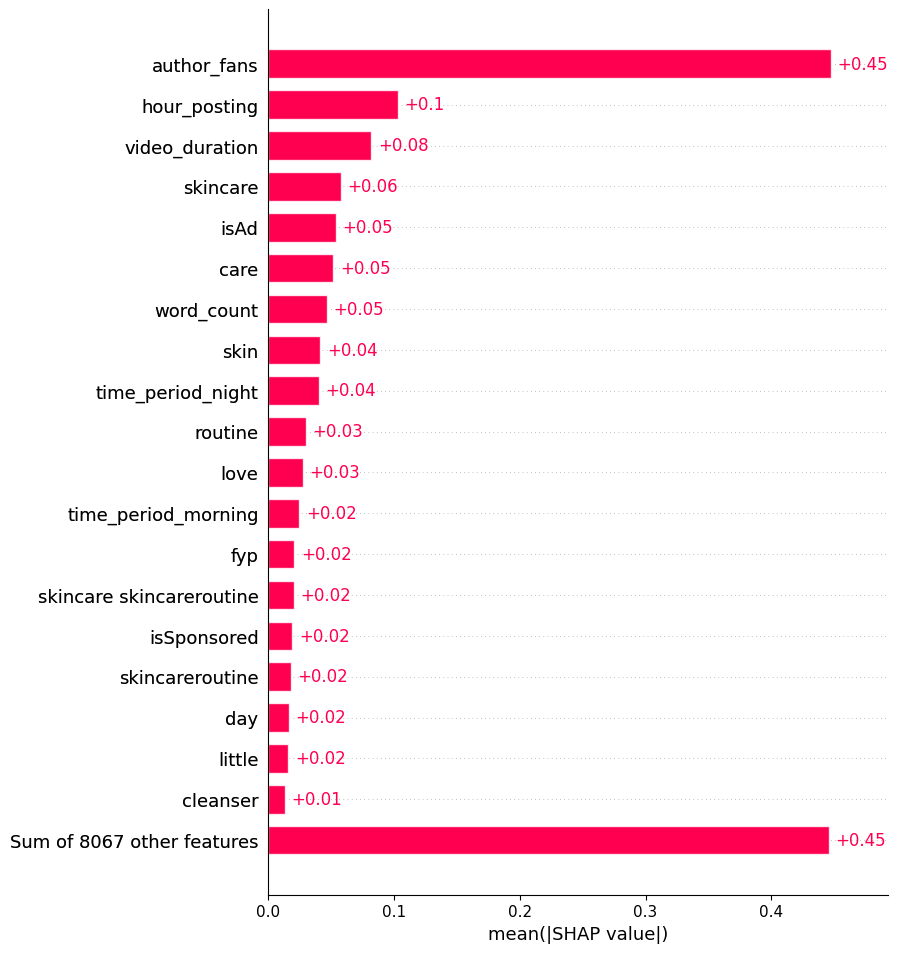

In [30]:
# mean absolute SHAP value per feature
shap_values = explainer(X_test_df)
shap.plots.bar(shap_values, max_display=20)

In [31]:
import numpy as np
import pandas as pd

# 1. build the full importance DataFrame
df_imp = (
    pd.DataFrame({
        "feature": feature_names,
        "mean_abs_shap": np.abs(shap_values.values).mean(axis=0)
    })
    .sort_values("mean_abs_shap", ascending=False)
    .reset_index(drop=True)
)

# 2. filter by threshold (10% of max)
thresh    = 0.1 * df_imp["mean_abs_shap"].max()
relevant  = df_imp[df_imp["mean_abs_shap"] >= thresh]

relevant_features = pd.DataFrame(relevant)
relevant_features

,feature,mean_abs_shap
0,author_fans,0.447162
1,hour_posting,0.102959
2,video_duration,0.082056
3,skincare,0.057677
4,isAd,0.053981
5,care,0.051643
6,word_count,0.046781


### Now lets look into the actual distribution, how the Shap values changes for each value

In [32]:
explainer = shap.Explainer(xgb, X_train_df)
shap_values = explainer(X_test_df)  

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


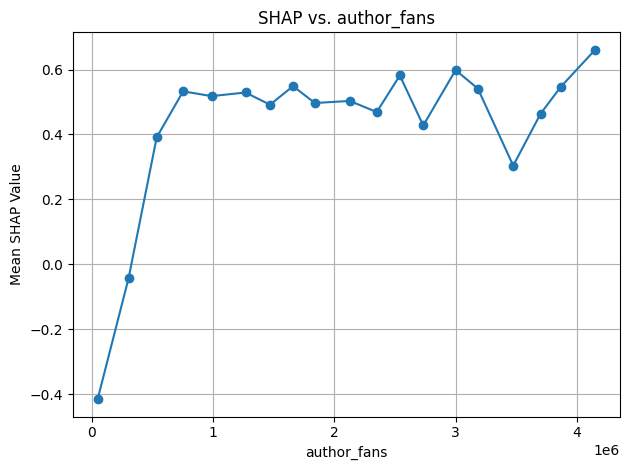

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


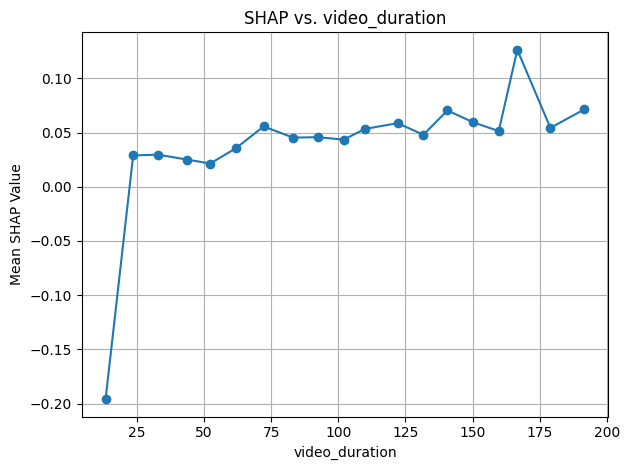

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/1657255722.py:37: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_plot.groupby("bin").agg(


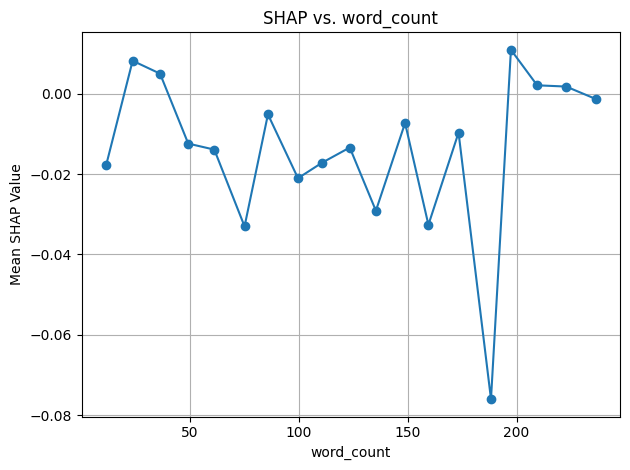

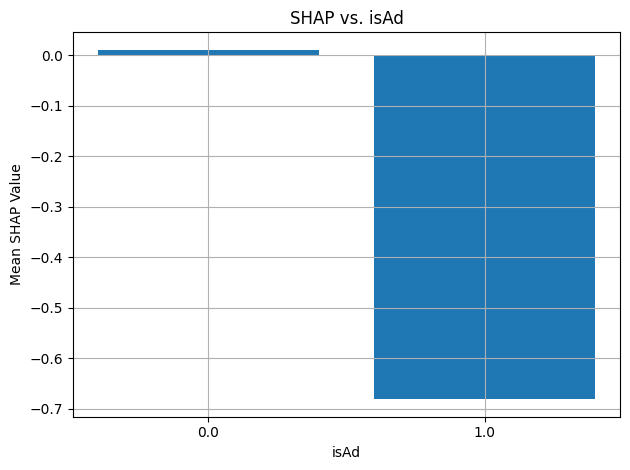

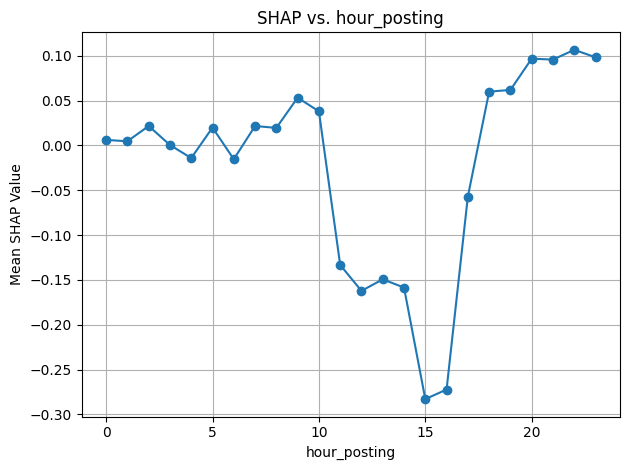

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top_features = ["author_fans", "video_duration", "word_count", "isAd", "hour_posting"]

for feature in top_features:
    #values = df_test_orig.loc[test_idx, feature].reset_index(drop=True)
    values = df_test_orig[feature].reset_index(drop=True)
    shap_vals = shap_values[:, feature].values.ravel()
    df_plot = pd.DataFrame({feature: values, "shap_value": shap_vals})

    # 1. Binary feature
    if set(df_plot[feature].dropna().unique()) <= {0, 1}:
        summary = df_plot.groupby(feature)["shap_value"].mean().reset_index()
        summary.rename(columns={"shap_value": "mean_shap_value"}, inplace=True)

        plt.figure()
        plt.bar(summary[feature].astype(str), summary["mean_shap_value"])

    # 2. Discrete feature like 'hour'
    elif feature == "hour_posting":
        summary = df_plot.groupby(feature)["shap_value"].mean().reset_index()
        summary.rename(columns={"shap_value": "mean_shap_value"}, inplace=True)

        plt.figure()
        plt.plot(summary[feature], summary["mean_shap_value"], marker="o")

    # 3. Continuous feature
    else:
        p5, p95 = np.percentile(values, [5, 95])
        df_plot = df_plot[(values >= p5) & (values <= p95)]

        bins = np.linspace(df_plot[feature].min(), df_plot[feature].max(), 20)
        df_plot["bin"] = pd.cut(df_plot[feature], bins=bins, include_lowest=True)

        summary = df_plot.groupby("bin").agg(
            mean_shap_value=("shap_value", "mean"),
            bin_center=(feature, "mean")
        ).dropna().reset_index()

        plt.figure()
        plt.plot(summary["bin_center"], summary["mean_shap_value"], marker="o")

    # Save and show
    summary.to_csv(f"shap_vs_{feature}.csv", index=False)
    plt.xlabel(feature)
    plt.ylabel("Mean SHAP Value")
    plt.title(f"SHAP vs. {feature}")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [34]:
print(xgb.__class__)               # Should be XGBRegressor
print(xgb.n_outputs_ if hasattr(xgb, 'n_outputs_') else "unknown")
print(shap_values.values.shape)      # Check for (731,) vs (731, 2)


<class 'xgboost.sklearn.XGBRegressor'>
unknown
(731, 8086)


/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


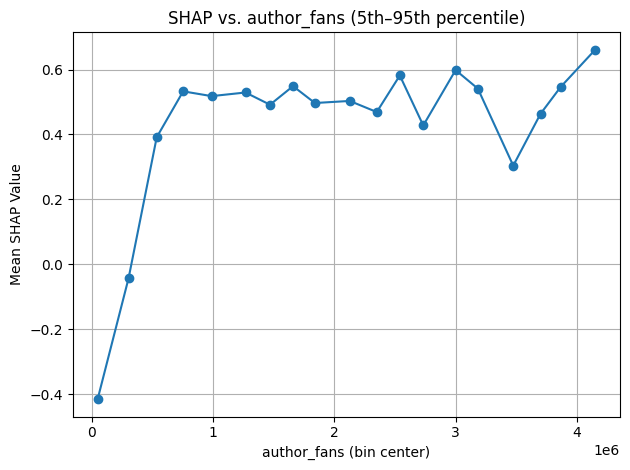

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


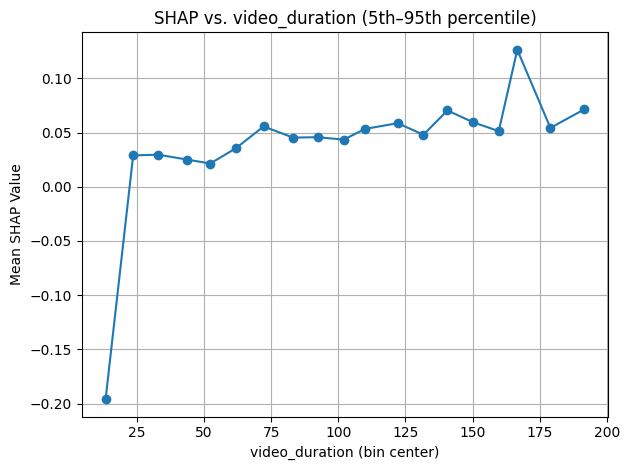

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df_plot.groupby("bin")["shap_value"].mean()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/3198212445.py:50: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_centers = df_plot.groupby("bin")[feature].mean()


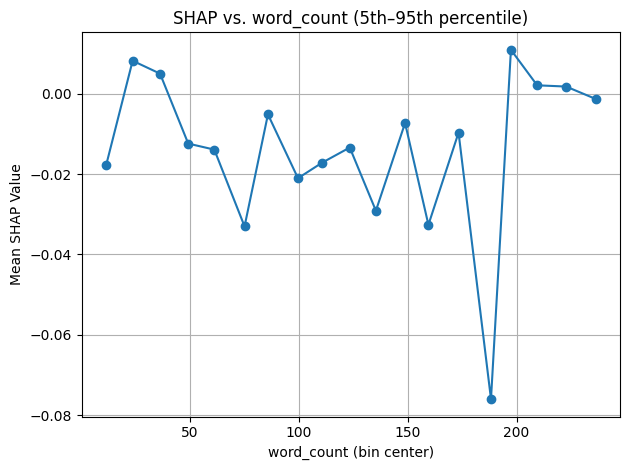

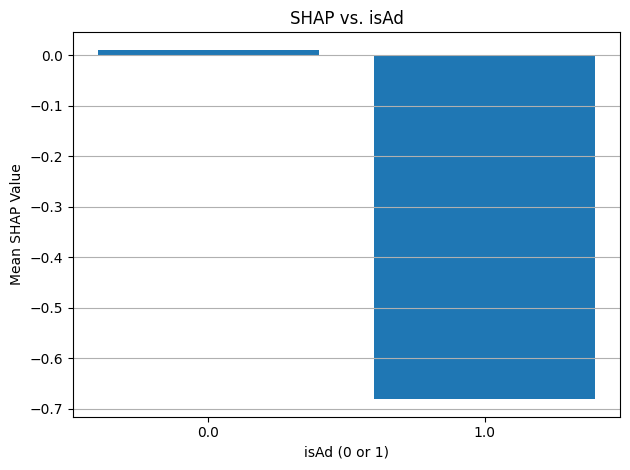

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

top_features = ["author_fans", "video_duration", "word_count", "isAd"]

for feature in top_features:
    # Get raw feature values from test set aligned with SHAP values
    feature_values = df_test_orig.loc[test_idx, feature].reset_index(drop=True)
    shap_val = shap_values[:, feature].values

    if feature == "isAd":
        # Binary feature → group by 0/1
        df_plot = pd.DataFrame({
            feature: feature_values,
            "shap_value": shap_val
        })

        group_means = df_plot.groupby(feature)["shap_value"].mean()
        output_df = group_means.reset_index().rename(columns={"shap_value": "mean_shap_value"})
        output_df.to_csv(f"shap_vs_{feature}.csv", index=False)

        # Bar plot
        plt.figure()
        plt.bar(output_df[feature].astype(str), output_df["mean_shap_value"])
        plt.xlabel(f"{feature} (0 or 1)")
        plt.ylabel("Mean SHAP Value")
        plt.title(f"SHAP vs. {feature}")
        plt.grid(True, axis="y")
        plt.tight_layout()
        plt.show()

    else:
        # Continuous feature → bin, filter, and plot
        p5, p95 = np.percentile(feature_values, [5, 95])
        mask = (feature_values >= p5) & (feature_values <= p95)

        filtered_vals = feature_values[mask]
        filtered_shap = shap_val[mask]

        df_plot = pd.DataFrame({
            feature: filtered_vals,
            "shap_value": filtered_shap
        })

        bin_edges = np.linspace(filtered_vals.min(), filtered_vals.max(), 20)
        df_plot["bin"] = pd.cut(df_plot[feature], bins=bin_edges, include_lowest=True)

        bin_means = df_plot.groupby("bin")["shap_value"].mean()
        bin_centers = df_plot.groupby("bin")[feature].mean()

        output_df = pd.DataFrame({
            f"{feature}_bin_center": bin_centers,
            "mean_shap_value": bin_means
        }).reset_index(drop=True)

        output_df.to_csv(f"shap_vs_{feature}.csv", index=False)

        plt.figure()
        plt.plot(output_df[f"{feature}_bin_center"], output_df["mean_shap_value"], marker="o")
        plt.xlabel(f"{feature} (bin center)")
        plt.ylabel("Mean SHAP Value")
        plt.title(f"SHAP vs. {feature} (5th–95th percentile)")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


Text(0.5, 1.0, 'Success Rate by Weekday')

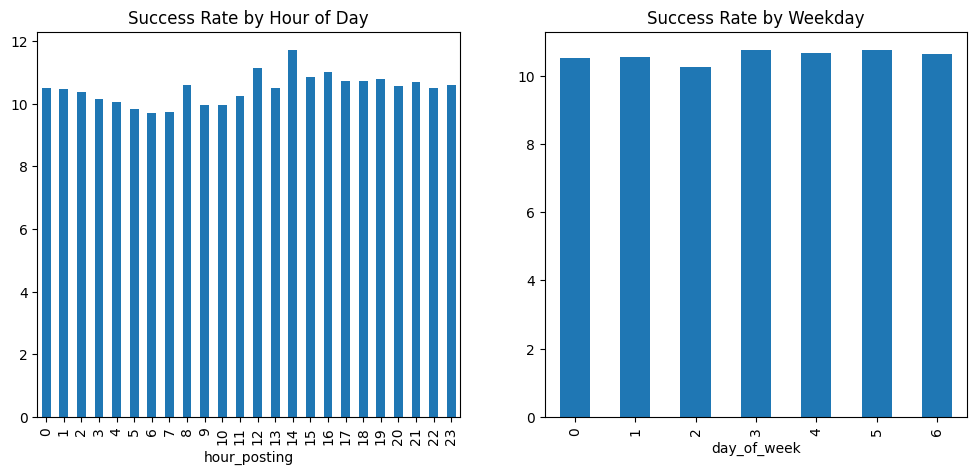

In [36]:
# Analyze success rate by hour
hourly_success = df.groupby('hour_posting')['viral_score'].mean()

# Analyze success rate by weekday
weekday_success = df.groupby('day_of_week')['viral_score'].mean()

# Visualize patterns
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
hourly_success.plot(kind='bar')
plt.title('Success Rate by Hour of Day')

plt.subplot(1,2,2)
weekday_success.plot(kind='bar')
plt.title('Success Rate by Weekday')


In [37]:
# Get feature names from TF-IDF vectorizer
tfidf_feature_names = vectorizer.get_feature_names_out()

# Find most important text features
text_feature_importances = pd.Series(
    xgb.feature_importances_[:len(tfidf_feature_names)],
    index=tfidf_feature_names
).sort_values(ascending=False)[:20]
text_feature_importances

convince                        0.008226
hautpflege                      0.006963
wrinkles                        0.005648
feel like                       0.005602
going                           0.005321
hope                            0.004660
wrong                           0.004629
gentle                          0.004613
update skincare                 0.004375
getreadywithme grwmaesthetic    0.004058
routine                         0.004032
skintransformation              0.003988
skin feel                       0.003962
viral                           0.003787
bar                             0.003751
didn                            0.003719
dermatology                     0.003698
hydration                       0.003678
cloudy                          0.003667
dia                             0.003648
dtype: float32

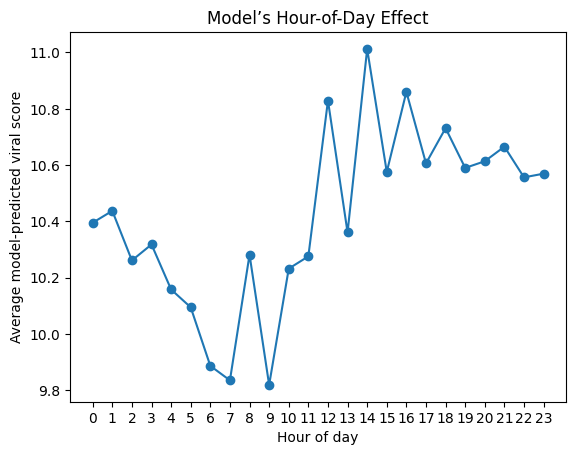

In [38]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Predict on your cleaned data
y_pred = xgb.predict(X_combined)   # or X_test if you want just test set
hours  = df_clean['hour_posting']          # same index as X_combined

# 2. Build DataFrame of hour vs. prediction
df_pred = pd.DataFrame({'hour_posting': hours, 'pred': y_pred})

# 3. Compute mean predicted viral_score by hour
hour_mean = df_pred.groupby('hour_posting')['pred'].mean().sort_index()

# 4. Plot
plt.plot(hour_mean.index, hour_mean.values, marker='o')
plt.xlabel('Hour of day')
plt.ylabel('Average model-predicted viral score')
plt.title('Model’s Hour-of-Day Effect')
plt.xticks(range(0,24))
plt.show()


### Train with is_viral

In [39]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y = df['is_viral']

idx = np.arange(X_combined.shape[0])
train_idx, test_idx = train_test_split(idx, test_size=0.2, random_state=42)

X_train = X_combined[train_idx]
X_test  = X_combined[test_idx]

y_train = y.iloc[train_idx]
y_test  = y.iloc[test_idx]

scale_pos_weight = 3.0 #0.75 / 0.25



xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=1,
    tree_method='hist',
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)
y_proba = xgb.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 score:", f1_score(y_test, y_pred))
print("AUC:", roc_auc_score(y_test, y_proba))


Accuracy: 0.6757865937072504
F1 score: 0.47912087912087914
AUC: 0.7161651362613858


In [41]:
shap_df = pd.DataFrame(shap_values.values, columns=shap_values.feature_names)
mean_abs_shap = shap_df.abs().mean().sort_values(ascending=False)
top_features = mean_abs_shap.head(30).index.tolist()  # or any top-N
X_train_top = X_train_df[top_features]
X_test_top  = X_test_df[top_features]


In [42]:
top_features

['author_fans',
 'hour_posting',
 'video_duration',
 'skincare',
 'isAd',
 'care',
 'word_count',
 'skin',
 'time_period_night',
 'routine',
 'love',
 'time_period_morning',
 'fyp',
 'skincare skincareroutine',
 'isSponsored',
 'skincareroutine',
 'day',
 'little',
 'cleanser',
 'avg_word_length',
 'mask',
 'come',
 'day_of_week',
 'skin1004',
 'right',
 'product',
 'morning',
 'time',
 'eye',
 'skincaretip']

In [43]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    scale_pos_weight=3.0,  # adjust for imbalance
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb.fit(X_train_top, y_train)

/Users/hannahschlaucher/Library/Caches/pypoetry/virtualenvs/skincare-analysis-pFfgqJ8c-py3.10/lib/python3.10/site-packages/xgboost/training.py:183: UserWarning: [22:42:00] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,'logloss'


In [44]:
from sklearn.metrics import classification_report

# Predict class probabilities
y_proba = xgb.predict_proba(X_test_top)[:, 1]

# Choose a threshold (e.g. 0.4 based on F1 curve)
threshold = 0.4
y_pred = (y_proba > threshold).astype(int)

# Print report
print(classification_report(y_test, y_pred, digits=3))


              precision    recall  f1-score   support

           0      0.846     0.567     0.679       524
           1      0.403     0.739     0.521       207

    accuracy                          0.616       731
   macro avg      0.624     0.653     0.600       731
weighted avg      0.721     0.616     0.634       731



In [61]:
import numpy as np
import pandas as pd

# 1) Inverse transform the scaled data
X_scaled = additional_data_scaled
means  = scaler.mean_
scales = scaler.scale_
X_orig = X_scaled * scales + means

# 2) Wrap in DataFrame
df_orig = pd.DataFrame(
    X_orig,
    columns=additional_cols_final,
    index=df_clean.index
)

# 3) Slice out rows matching train/test split and SHAP inputs
df_train_orig = df_orig.loc[X_train_top.index].reset_index(drop=True)
df_test_orig  = df_orig.loc[X_test_top.index].reset_index(drop=True)

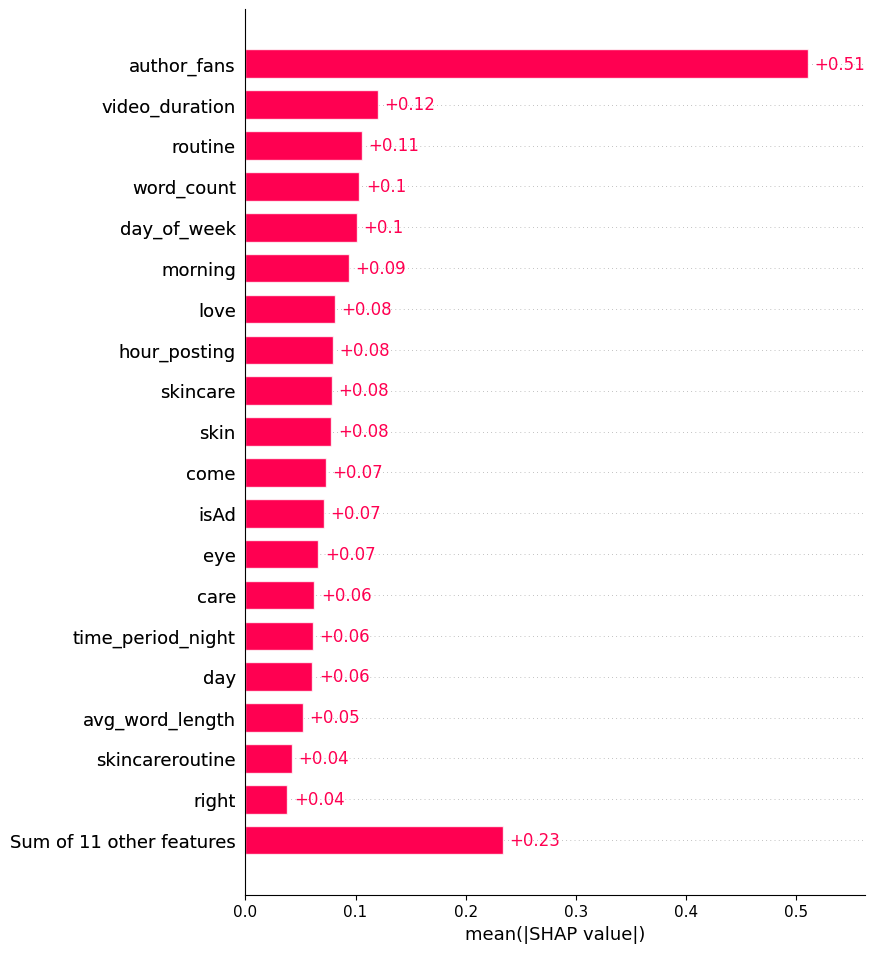

In [68]:
import shap

explainer = shap.Explainer(xgb, X_train_top)
shap_values = explainer(X_test_top)

shap.plots.bar(shap_values, max_display=20)  # Global importance


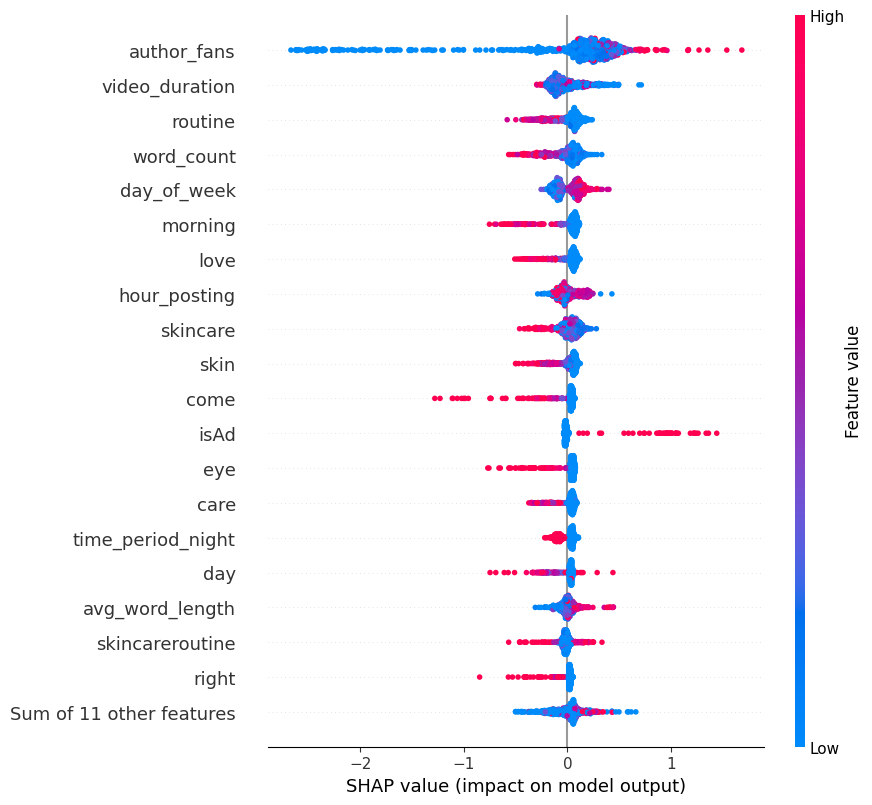

In [63]:
shap.plots.beeswarm(shap_values, max_display=20)  # Dots colored by feature value


In [81]:
top_features = ["author_fans", "video_duration", "word_count", "isAd", "hour_posting"]


In [ ]:
relevant_features.drop()

['video_duration', 'author_fans', 'word_count']

In [83]:
relevant_features = relevant_features[relevant_features["feature"].isin(top_features)].reset_index(drop=True)


In [85]:

# Prepare list to store ranges
optimal_ranges = []

for feat in top_features:
    df_feat = pd.DataFrame({
        "feature_val": df_test_orig[feat].values,
        "shap_val": shap_values[:, feat].values
    })

    # Remove outliers
    p1, p99 = np.percentile(df_feat["feature_val"], [1, 99])
    df_feat = df_feat[(df_feat["feature_val"] >= p1) & (df_feat["feature_val"] <= p99)]

    # Bin + compute mean SHAP
    bins = pd.cut(df_feat["feature_val"], bins=100)
    summary = df_feat.groupby(bins)["shap_val"].mean()

    # Get bin with max SHAP value
    if not summary.empty:
        best_bin = summary.idxmax()
        best_range = f"{best_bin.left:.1f}–{best_bin.right:.1f}"
    else:
        best_range = "n/a"

    optimal_ranges.append(best_range)

# Add as new column
relevant_features["optimal_value_range"] = optimal_ranges

relevant_features.to_csv("successful_post_range.csv")

/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/2013610062.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_feat.groupby(bins)["shap_val"].mean()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/2013610062.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = df_feat.groupby(bins)["shap_val"].mean()
/var/folders/rx/4hst61c96_bfm0gnxrq_5w_h0000gn/T/ipykernel_12437/2013610062.py:16: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obser

# Old

In [66]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor


# drop all unwanted cols
X = df.drop([
    'post_id',
    'is_viral',
    'diggCount',
    'shareCount',
    'playCount',
    'collectCount',
    'commentCount',
    'engagement',
    'searchHashtag_name',
    'searchHashtag_views',
    'author_nickName',
    'detected_language',
    'textLanguage',
    'date',
    'createTimeISO',
    'author_signature',
    'location_address',
    'transcribed_text',
    'video_description',
    'hashtag_text',
    'text_all',
    'success_score',
    'viral_score',
], axis=1)

y = df['viral_score']

# split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preprocessor = ColumnTransformer(
    transformers=[
        ('text', TfidfVectorizer(max_features=10000, ngram_range=(1,3)), 'text'),
        ('num', StandardScaler(),      ['author_fans','video_duration']),
        ('bin', 'passthrough',         ['isAd','isSponsored']),
    ],
    remainder='passthrough'
)

pipeline = Pipeline([
    ('pre', preprocessor),
    ('reg', XGBRegressor(
        objective='reg:squarederror',
        n_estimators=400,
        max_depth=6,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        tree_method='hist',
        random_state=42
    ))
])

# CV
cv_mae = -cross_val_score(
    pipeline, X_train, y_train,
    cv=5, scoring='neg_mean_absolute_error', n_jobs=-1
).mean()
print(f"CV MAE: {cv_mae:.3f}")

KeyError: "['engagement', 'hashtag_text', 'success_score'] not found in axis"

In [ ]:
# final fit with early stopping
pipeline.fit(
    X_train, y_train,
)

# test MAE
print("Test MAE:", mean_absolute_error(y_test, pipeline.predict(X_test)))

In [ ]:
print("feature_names_in_:", preprocessor.feature_names_in_)


In [ ]:
feature_names = preprocessor.get_feature_names_out()

In [ ]:
# grab fitted ColumnTransformer
pre = pipeline.named_steps['pre']

# this array is exactly what the transformer saw when fitting
in_feats = pre.feature_names_in_

# now request the output names
feat_names = pre.get_feature_names_out(input_features=in_feats)


In [ ]:
input_feats = np.array(X_train.columns, dtype=pre.feature_names_in_.dtype)
assert np.array_equal(input_feats, pre.feature_names_in_)
feat_names = pre.get_feature_names_out(input_features=input_feats)


In [ ]:
import shap
pre = pipeline.named_steps['pre']
feat_names = pre.get_feature_names_out()

# explainer
explainer = shap.Explainer(pipeline.named_steps['reg'], pipeline.named_steps['pre'].transform(X_train))
shap_values = explainer(pipeline.named_steps['pre'].transform(X_test))

# summary plot: shows feature impact direction
shap.summary_plot(shap_values, pipeline.named_steps['pre'].transform(X_test), feat_names)


In [ ]:
# 2 — feature names after all preprocessing
feat_names = pipeline.named_steps['pre'].get_feature_names_out()


imp = pipeline.named_steps['reg'].feature_importances_

# 4 — rank
order = np.argsort(imp)          # ascending
top_neg = [(feat_names[i], imp[i]) for i in order[:20]]          # worst
top_pos = [(feat_names[i], imp[i]) for i in order[-20:][::-1]]   # best

print("↑ success:", top_pos)
print("↓ success:", top_neg)


In [ ]:
import numpy as np
import pandas as pd

# 1. Grab the fitted preprocessor and regressor
pre = pipeline.named_steps['pre']
reg = pipeline.named_steps['reg']

# 2. Build the full feature‐name list in the same order the model sees them
#   a) text features
text_feats = pre.named_transformers_['text'].get_feature_names_out()
#   b) numeric + binary features (in the order you passed them)
num_feats = ['author_fans', 'video_duration']
bin_feats = ['isAd', 'isSponsored']
feature_names = np.concatenate([text_feats, num_feats, bin_feats])

# 3. Pair names with importances & sort
importances = reg.feature_importances_
feat_imp = pd.Series(importances, index=feature_names)
feat_imp = feat_imp.sort_values(ascending=False)

# 4. Show top 10
print(feat_imp.head(40))


In [ ]:
# after model.fit(...)
names = model.named_steps['pre'].get_feature_names_out()
imp   = model.named_steps['clf'].feature_importances_

# sort ascending ⇒ smallest gains first
irrelevant = (
    pd.Series(imp, index=names)
      .sort_values(ascending=True)
)

# show bottom 30 (near-zero = basically unused)
print(irrelevant.head(30))

In [ ]:

# 2 — isolate pieces
prep  = pipeline.named_steps['pre']
clf   = pipeline.named_steps['clf']
names = prep.get_feature_names_out()



# 4 — build explainer (LinearExplainer fits logistic/linear models)
expl = shap.LinearExplainer(clf, X_tr, feature_names=names)

# 5 — global view
shap_values = expl(X_va)              # SHAP for validation rows
shap.summary_plot(shap_values, X_va, feature_names=names, max_display=25)

# 6 — single-post waterfall
idx = 0                                # any row index
shap.waterfall_plot(shap_values[idx], max_display=20)
